0/30 ; 0/30
0/30 ; 1/30
0/30 ; 2/30
0/30 ; 3/30
0/30 ; 4/30
0/30 ; 5/30
0/30 ; 6/30
0/30 ; 7/30
0/30 ; 8/30
0/30 ; 9/30
0/30 ; 10/30
0/30 ; 11/30
0/30 ; 12/30
0/30 ; 13/30
0/30 ; 14/30
0/30 ; 15/30
0/30 ; 16/30
0/30 ; 17/30
0/30 ; 18/30
0/30 ; 19/30
0/30 ; 20/30
0/30 ; 21/30
0/30 ; 22/30
0/30 ; 23/30
0/30 ; 24/30
0/30 ; 25/30
0/30 ; 26/30
0/30 ; 27/30
0/30 ; 28/30
0/30 ; 29/30
1/30 ; 0/30
1/30 ; 1/30
1/30 ; 2/30
1/30 ; 3/30
1/30 ; 4/30
1/30 ; 5/30
1/30 ; 6/30
1/30 ; 7/30
1/30 ; 8/30
1/30 ; 9/30
1/30 ; 10/30
1/30 ; 11/30
1/30 ; 12/30
1/30 ; 13/30
1/30 ; 14/30
1/30 ; 15/30
1/30 ; 16/30
1/30 ; 17/30
1/30 ; 18/30
1/30 ; 19/30
1/30 ; 20/30
1/30 ; 21/30
1/30 ; 22/30
1/30 ; 23/30
1/30 ; 24/30
1/30 ; 25/30
1/30 ; 26/30
1/30 ; 27/30
1/30 ; 28/30
1/30 ; 29/30
2/30 ; 0/30
2/30 ; 1/30
2/30 ; 2/30
2/30 ; 3/30
2/30 ; 4/30
2/30 ; 5/30
2/30 ; 6/30
2/30 ; 7/30
2/30 ; 8/30
2/30 ; 9/30
2/30 ; 10/30
2/30 ; 11/30
2/30 ; 12/30
2/30 ; 13/30
2/30 ; 14/30
2/30 ; 15/30
2/30 ; 16/30
2/30 ; 17/30
2/30 ; 18/30
2/3

<ipython-input-2-d660dbe825b7>:55: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, _, _, _ = np.linalg.lstsq(A, b)


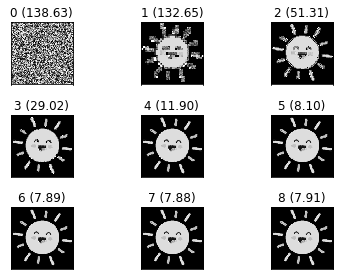

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from scipy import optimize
import numpy as np
import math

#Manipulação de canais de cor - escala de cinza
def get_greyscale_image(img):
    return np.mean(img[:,:,:2], 2)

#Transformações
#A função reduce reduz o tamanho da imagem através do cálculo da média dos pontos vizinhos:
def reduce(img, factor):
    result = np.zeros((img.shape[0] // factor, img.shape[1] // factor))
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i,j] = np.mean(img[i*factor:(i+1)*factor,j*factor:(j+1)*factor])
    return result

#A função rotate gira de acordo com o ângulo dado, que estará em {0°, 90°, 180°, 270°}, como forma de preservar a imagem:
def rotate(img, angle):
    return ndimage.rotate(img, angle, reshape=False)

#A função flip inverte a imagem se direction = -1 e não inverte se direction = 1:
def flip(img, direction):
    return img[::direction,:]

#Toda a transformação é feita pela função a seguir:
def apply_transformation(img, direction, angle, contrast=1.0, brightness=0.0):
    return contrast*rotate(flip(img, direction), angle) + brightness

#Compressão para imagens greyscale
#Na função abaixo, são geradas todas as transformações possíveis de todos os blocos de origem:
def generate_all_transformed_blocks(img, source_size, destination_size, step):
    factor = source_size // destination_size
    transformed_blocks = []
    for k in range((img.shape[0] - source_size) // step + 1):
        for l in range((img.shape[1] - source_size) // step + 1):
            #Extrai o bloco de origem e reduz ele pro tamanho do bloco de destino
            S = reduce(img[k*step:k*step+source_size,l*step:l*step+source_size], factor)
            #Gerando todos os possiveis blocos 
            for direction, angle in candidates:
                transformed_blocks.append((k, l, direction, angle, apply_transformation(S, direction, angle)))
    return transformed_blocks

#Contraste e brilho
#Para cada bloco de destino, são testados todos os blocos de origem transformados anteriormente
#Para cada bloco, o contraste e o brilho são otimizados na função abaixo, que resolve um simples problema de quadrados mínimos:
def find_contrast_and_brightness2(D, S):
    #Encaixando o contraste e o brilho 
    A = np.concatenate((np.ones((S.size, 1)), np.reshape(S, (S.size, 1))), axis=1)
    b = np.reshape(D, (D.size,))
    x, _, _, _ = np.linalg.lstsq(A, b)
    
    return x[1], x[0]


#Se a transformação testada for a melhor, ela é salva na função abaixo:
def compress(img, source_size, destination_size, step):
    transformations = []
    transformed_blocks = generate_all_transformed_blocks(img, source_size, destination_size, step)
    i_count = img.shape[0] // destination_size
    j_count = img.shape[1] // destination_size
    for i in range(i_count):
        transformations.append([])
        for j in range(j_count):
            print("{}/{} ; {}/{}".format(i, i_count, j, j_count))
            transformations[i].append(None)
            min_d = float('inf')
            #Extrai o bloco de destino 
            D = img[i*destination_size:(i+1)*destination_size,j*destination_size:(j+1)*destination_size]
            #Testa todas as possiveis transformações e pega a melhor delas 
            for k, l, direction, angle, S in transformed_blocks:
                contrast, brightness = find_contrast_and_brightness2(D, S)
                S = contrast*S + brightness
                d = np.sum(np.square(D - S))
                if d < min_d:
                    min_d = d
                    transformations[i][j] = (k, l, direction, angle, contrast, brightness)
    return transformations

#Para descomprimir a imagem, aplica-se a contração f várias vezes; 
#A descompressão funciona porque a contração tem um ponto fixo único:
def decompress(transformations, source_size, destination_size, step, nb_iter=8):
    factor = source_size // destination_size
    height = len(transformations) * destination_size
    width = len(transformations[0]) * destination_size
    iterations = [np.random.randint(0, 256, (height, width))]
    cur_img = np.zeros((height, width))
    for i_iter in range(nb_iter):
        print(i_iter)
        for i in range(len(transformations)):
            for j in range(len(transformations[i])):
                #Aplicando a transformação
                k, l, flip, angle, contrast, brightness = transformations[i][j]
                S = reduce(iterations[-1][k*step:k*step+source_size,l*step:l*step+source_size], factor)
                D = apply_transformation(S, flip, angle, contrast, brightness)
                cur_img[i*destination_size:(i+1)*destination_size,j*destination_size:(j+1)*destination_size] = D
        iterations.append(cur_img)
        cur_img = np.zeros((height, width))
    return iterations

#Plotando as iterações
def plot_iterations(iterations, target=None):
    
    plt.figure()
    nb_row = math.ceil(np.sqrt(len(iterations)))
    nb_cols = nb_row
    
    for i, img in enumerate(iterations):
        plt.subplot(nb_row, nb_cols, i+1)
        plt.imshow(img, cmap='gray', vmin=0, vmax=255, interpolation='none')
        if target is None:
            plt.title(str(i))
        else:
            
            plt.title(str(i) + ' (' + '{0:.2f}'.format(np.sqrt(np.mean(np.square(target - img)))) + ')')
        frame = plt.gca()
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)
    plt.tight_layout()

#Parâmetros
directions = [1, -1]
angles = [0, 90, 180, 270]
candidates = [[direction, angle] for direction in directions for angle in angles]

#Teste
#A função abaixo carrega a imagem, compacta, descompacta e mostra iteração por iteração do processo de descompressão:
def test_greyscale():
    img = mpimg.imread('sun.gif')
    img = get_greyscale_image(img)
    img = reduce(img, 4)
    plt.figure()
    plt.imshow(img, cmap='gray', interpolation='none')
    transformations = compress(img, 8, 4, 8)
    iterations = decompress(transformations, 8, 4, 8)
    plot_iterations(iterations, img)
    plt.show()

                    
if __name__ == '__main__':
    test_greyscale()
    